## PLAYR statistics

In [ ]:
import requests
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns
from skimage.io import imshow

In [ ]:
def auth(url, params):
    try:
        result = requests.post(url, data=params)
        return result.status_code, result.text
    except:
        return None, None     

## All links

* https://playr.playertek.com/v1/session/3120257/stats/distance

* /v1/session/3120257/positional/splits
* /v1/session/3120257/fiveminute
* /v1/session/3120257/heatmap?xRes=231&yRes=131
* /v1/session/3120257/powerplays

* /v1/session/3120257

## Authorization

In [ ]:
base_url = 'https://playr.playertek.com/v1/'
auth_url = base_url + 'user/login'

In [ ]:
status, auth_response = auth(auth_url, {"userName":"","password":""})
status

In [ ]:
for k, v in json.loads(auth_response).items():
    print(k, v)

In [ ]:
session_token = json.loads(auth_response)["sessionToken"]

## Get sessions list

In [19]:
sessions_url = base_url + 'session/cards/list/'

In [20]:
r = requests.get(sessions_url, headers={'x-xsrf-token': session_token})
print(r.status_code)
sessions_list = json.loads(r.text)['sessionCards']
print(f'sessions count = {len(sessions_list)}')

200
sessions count = 26


In [ ]:
with open('sessions_list.json', 'w') as f:
    f.write(json.dumps(sessions_list))

In [ ]:
# sessions_list[0]

In [ ]:
sessions_list[1]

In [ ]:
lst = []
# Iterate through sessions
for sess in sessions_list:
    lsti = []
    headers = []
    for key, value in sess.items():
        if key != 'metrics': # ignore metrics list
            lsti.append(value)
            if len(headers) < len(sess) - 1:
                headers.append(key)
    
    # look at metrics list       
    for metric in sess['metrics']:
        metric_name = metric['metricName']
        headers += [metric_name, metric_name + '_unit']
        lsti += [metric['value'], metric['unit']]
    
    lst.append(lsti)

sess_tiny = pd.DataFrame(lst, columns=headers)

# Convert fields
for column in ['sessionId', 'sessionType', 'hasBeenSetup', 'minsPlayed', 
               'ourGoals', 'theirGoals', 'powerPlays', 'sprintDistance']:
    sess_tiny[column] = sess_tiny[column].astype(int)
for column in ['distance', 'topSpeed']:
    sess_tiny[column] = sess_tiny[column].astype(float)

# sess_tiny['timestampStart'] = sess_tiny['timestampStart'].map(lambda x: 
#                                                 datetime.utcfromtimestamp(int(x[:-3])).strftime('%Y-%m-%d %H:%M:%S'))
# sess_tiny['timestampStart'] = pd.to_datetime(sess_tiny['timestampStart'])

# for i in range(len(sess_tiny)):
#     sess_tiny.loc[i, 'timestampFinish'] = sess_tiny.loc[i ,'timestampStart'] + pd.Timedelta(minutes=sess_tiny.loc[i, 'minsPlayed'])

# Sorting sessions by ID
sess_tiny.sort_values(by='sessionId', inplace=True)

print(sess_tiny)
print(sess_tiny.info())

# Grab all data

In [21]:
data = []

# urls list
base_url = 'https://playr.playertek.com/v1/'
session_url = 'session/%s/'
fiveminute_url = 'session/%s/fiveminute/'
powerplays_url = 'session/%s/powerplays/'
dist_heatmap_url = 'session/%s/heatmap?xRes=%s&yRes=%s'
stats_distance_url = 'session/%s/stats/distance/'
positional_splits_url = 'session/%s/positional/splits/'
positional_url = 'session/%s/positional/'
pitch_url = 'pitch/%s'

for i, session in enumerate(sessions_list[:1]):
    session_id = session['sessionId']
    print(f'[{"0"*(len(str(len(sessions_list))) - len(str(i + 1))) + str(i + 1)}/{len(sessions_list)}] Session id = {session_id}')
    data_chunk = {'session_id': session_id}
    
    # get common info
    r = requests.get(base_url + session_url % session_id, headers={'x-xsrf-token': session_token})
    print(base_url + session_url % session_id, r.status_code)
    session_info = json.loads(r.text)
    pitch_id = session_info['pitchId']
    data_chunk['info'] = session_info
    
    # get five minute info
    r = requests.get(base_url + fiveminute_url % session_id, headers={'x-xsrf-token': session_token})
    print(base_url + fiveminute_url % session_id, r.status_code)
    session_fivemin = json.loads(r.text)
    data_chunk['fivemin'] = session_fivemin
    
    # get powerplays info
    r = requests.get(base_url + powerplays_url % session_id, headers={'x-xsrf-token': session_token})
    print(base_url + powerplays_url % session_id, r.status_code)
    session_powerplays = json.loads(r.text)
    data_chunk['powerplays'] = session_powerplays
    
    # get positional path info
    r = requests.get(base_url + positional_url % session_id, headers={'x-xsrf-token': session_token})
    print(base_url + positional_url % session_id, r.status_code)
    session_positional_path = json.loads(r.text)
    data_chunk['positional'] = session_positional_path
    
    # get heatmap info
    r = requests.get(base_url + dist_heatmap_url % (session_id, 231, 131), headers={'x-xsrf-token': session_token})
    print(base_url + dist_heatmap_url % (session_id, 231, 131), r.status_code)
    session_heatmap = json.loads(r.text)
    data_chunk['heatmap'] = session_heatmap

    # get stats distance info
    r = requests.get(base_url + stats_distance_url % session_id, headers={'x-xsrf-token': session_token})
    print(base_url + stats_distance_url % session_id, r.status_code)
    session_stats_distance = json.loads(r.text)
    data_chunk['stats_distance'] = session_stats_distance
    
    # get positional splits info
    r = requests.get(base_url + positional_splits_url % session_id, headers={'x-xsrf-token': session_token})
    print(base_url + positional_splits_url % session_id, r.status_code)
    session_positional_splits = json.loads(r.text)
    data_chunk['positional_splits'] = session_positional_splits
    
    # get pitch info
    r = requests.get(base_url + pitch_url % pitch_id, headers={'x-xsrf-token': session_token})
    print(base_url + pitch_url % pitch_id, r.status_code)
    session_pitch = json.loads(r.text)
    data_chunk['pitch'] = session_pitch
    
    data.append(data_chunk)

[01/26] Session id = 6253822
https://playr.playertek.com/v1/session/6253822/ 200
https://playr.playertek.com/v1/session/6253822/fiveminute/ 200
https://playr.playertek.com/v1/session/6253822/powerplays/ 200
https://playr.playertek.com/v1/session/6253822/positional/ 200
https://playr.playertek.com/v1/session/6253822/heatmap?xRes=231&yRes=131 200
https://playr.playertek.com/v1/session/6253822/stats/distance/ 200
https://playr.playertek.com/v1/session/6253822/positional/splits/ 200
https://playr.playertek.com/v1/pitch/615507 200


In [ ]:
data[0].keys()

In [ ]:
data[0]['info']

In [ ]:
data[0]['positional']

In [ ]:
with open('sessions_20201008.json', 'w') as f:
    f.write(json.dumps(data))

## Get sessions

In [22]:
session_url = '/session/%s/'

In [ ]:
sessions = []
for sess_id in list(sess_tiny['sessionId'])[:]:
    
    print(f'session id = {sess_id}')
    r = requests.get(base_url + session_url % sess_id, headers={'x-xsrf-token': session_token})
    print(r.status_code)
    sess = json.loads(r.text)
    sessions.append(sess)

print(f'Captured sessions = {len(sessions)}')

In [ ]:
sessions[1]

In [ ]:
sessions[-1]

In [ ]:
lst = []
excluded_keys = ['plannedSession']
for sess in sessions[:]: 
    lsti = []
    headers = []
    for key, value in sess.items():
        if key not in excluded_keys:
            lsti.append(value)
            if len(headers) < len(sess) - len(excluded_keys):
                headers.append(key)
    
    # look at metrics list       
    for excl_field in excluded_keys:
        
        # dict parameters
        if isinstance(sess[excl_field], dict):
            lsti.append(True)
            headers.append(excl_field)
            for excl_key, excl_value in sess[excl_field].items():
                lsti.append(excl_value)
                if excl_key in headers:
                    excl_key = excl_field + '_' + excl_key
                headers.append(excl_key)
        elif isinstance(sess[excl_field], list):
            pass # TODO: if it exists
        elif sess[excl_field] is None:
            lsti.append(None)
            headers.append(excl_field)
        else:
            lsti.append(None)
            headers.append(excl_field)
    
    lst.append(lsti)

sess_df = pd.DataFrame(lst, columns=headers)
    
print(sess_df.head(10))
print(sess_df.info())

### Convert values

In [ ]:
for column in ['sessionTimestampStart', 'sessionTimestampEnd']:
    if column in list(sess_df.columns) and str(sess_df[column].dtype) != 'datetime64[ns]':
        sess_df[column] = sess_df[column].map(lambda x: 
                                              datetime.utcfromtimestamp(int(x[:-3])).strftime('%Y-%m-%d %H:%M:%S'))
        sess_df[column] = pd.to_datetime(sess_df[column])
    
for column in ['startTime', 'endTime']:
    if str(sess_df[column].dtype) != 'datetime64[ns]':
        sess_df[column] = sess_df[column].map(lambda x: 
                                              datetime.utcfromtimestamp(int(x[:-5])).strftime('%Y-%m-%d %H:%M:%S'))
        sess_df[column] = pd.to_datetime(sess_df[column])

columns_integer = ['sessionId', 'playerId', 'sessionGroupId', 'sessionType', 'halfDuration', 
               'pitchId', 'playedStartOffset', 'playedEndOffset', 'trainingDuration', 
               'hasProMatch', 'isDirectionPlayUp', 'sessionPowerPlays', 'sessionSprintDistanceM', 
               'caloriesBurned', 'isUsingGameActivity', 'firstHalfIsDirectionUp']

columns_float = ['sessionDistanceM', 'sessionTopSpeedMS']

for column in columns_integer:
    try:
        sess_df[column] = sess_df[column].astype(int)
    except:
        print(column, 'error')
        
for column in columns_float:
    try:
        sess_df[column] = sess_df[column].astype(float)
    except:
        print(column, 'error')
        
# Convert 'firstHalfStartTime', 'secondHalfStartTime'
    
print(sess_df.dtypes)

## Get fiveminutes

In [ ]:
fiveminute_url = '/session/%s/fiveminute/'

for sess_id in ['2947648']: # list(sess_df['sessionId'])[:1]:

    print(sess_id)
    r = requests.get(base_url + fiveminute_url % sess_id, headers={'x-xsrf-token': session_token})
    print(r.status_code)
    sess_fivemin = json.loads(r.text)

In [ ]:
print(sess_fivemin)

In [ ]:
for fiveminutes in sess_fivemin:
    print(len(fiveminutes['data']))
    for k, v in fiveminutes.items():
        print(k, v)

In [ ]:
sess_df.loc[sess_df['sessionId'] == 2947648, 'distance'].values[0]

## Heatmap

In [28]:
dist_heatmap_url = 'session/%s/heatmap?xRes=%s&yRes=%s'
sess_id = '2947648'
print(base_url + dist_heatmap_url % (sess_id, 231, 131))
r = requests.get(base_url + dist_heatmap_url % (sess_id, 231, 131), headers={'x-xsrf-token': session_token})
print(r.status_code)
heatmap = json.loads(r.text)

https://playr.playertek.com/v1/session/2947648/heatmap?xRes=231&yRes=131
200


In [29]:
heatmap.keys()

dict_keys(['all'])

In [30]:
df = pd.DataFrame(heatmap['all']['heatmap']['data'], columns=['y', 'x', 'v'])

print(df.head())
print(df.describe())

   y   x     v
0  0  18  0.02
1  0  22  0.00
2  0  25  0.04
3  0  59  0.06
4  0  63  0.06
                 y            x            v
count  1449.000000  1449.000000  1449.000000
mean    102.349896    69.616977     0.180531
std      58.647861    30.999047     0.176949
min       0.000000     5.000000     0.000000
25%      53.000000    44.000000     0.050000
50%     102.000000    70.000000     0.120000
75%     150.000000    95.000000     0.240000
max     228.000000   128.000000     1.000000


In [31]:
hm_matrix = np.zeros((231,131))
print(hm_matrix.shape)

for i in range(len(df)):
    y, x, v = df.loc[i, 'y':'v']
#     hm_matrix[y][x] = v
    hm_matrix.itemset((int(y), int(x)), v)

(231, 131)


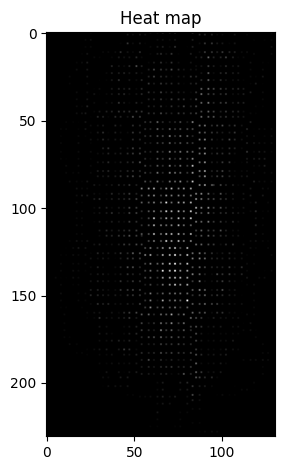

In [32]:
fig, ax = plt.subplots()
im = ax.imshow(hm_matrix, cmap="gray")

ax.set_title("Heat map")
fig.tight_layout()
plt.show()

In [33]:
lst = []
for i in range(len(df)):
    y, x, v = df.loc[i, 'y':'v']
    for i in range(int(v * 50)):
        lst.append([x, y])
        
df_sns = pd.DataFrame(lst, columns=['x', 'y'])

In [34]:
df_sns.describe()

,x,y
count,12800.000000,12800.000000
mean,72.609297,104.690781
std,21.076667,48.232437
min,5.000000,0.000000
25%,59.000000,69.000000
50%,73.000000,106.000000
75%,87.000000,140.000000
max,128.000000,228.000000


In [ ]:
#Create figure
color = 'white'
fig=plt.figure()
fig.set_size_inches(7, 5)
ax=fig.add_subplot(1,1,1)

#Pitch Outline & Centre Line
plt.plot([0,0],[0,90], color=color)
plt.plot([0,130],[90,90], color=color)
plt.plot([130,130],[90,0], color=color)
plt.plot([130,0],[0,0], color=color)
plt.plot([65,65],[0,90], color=color)

#Left Penalty Area
plt.plot([16.5,16.5],[65,25],color=color)
plt.plot([0,16.5],[65,65],color=color)
plt.plot([16.5,0],[25,25],color=color)

#Right Penalty Area
plt.plot([130,113.5],[65,65],color=color)
plt.plot([113.5,113.5],[65,25],color=color)
plt.plot([113.5,130],[25,25],color=color)

#Left 6-yard Box
plt.plot([0,5.5],[54,54],color=color)
plt.plot([5.5,5.5],[54,36],color=color)
plt.plot([5.5,0.5],[36,36],color=color)

#Right 6-yard Box
plt.plot([130,124.5],[54,54],color=color)
plt.plot([124.5,124.5],[54,36],color=color)
plt.plot([124.5,130],[36,36],color=color)

#Prepare Circles
centreCircle = plt.Circle((65,45),9.15,color=color,fill=False)
centreSpot = plt.Circle((65,45),0.8,color=color)
leftPenSpot = plt.Circle((11,45),0.8,color=color)
rightPenSpot = plt.Circle((119,45),0.8,color=color)

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

#Prepare Arcs
leftArc = Arc((11,45),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color=color)
rightArc = Arc((119,45),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color=color)

#Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

#Tidy Axes
plt.axis('off')

sns.kdeplot(df_sns["y"]/231*130, df_sns["x"]/131*90, shade=True, n_levels=50, cmap="CMRmap")
plt.ylim(0, 90)
plt.xlim(0, 130)

#Display Pitch
plt.show()

In [ ]:
'''
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, 
Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, 
Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, 
PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, 
RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, 
Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, 
autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, 
coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, 
gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, 
gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, 
hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, 
nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, 
rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, 
tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, 
twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r
'''

In [ ]:
#Create figure
color = 'white'

fig=plt.figure()
fig.set_size_inches(5, 7)
ax=fig.add_subplot(1, 1, 1)

#Pitch Outline & Centre Line
# x1 x2  - y1 y2
plt.plot([0, 0], [0, 130], color=color) # left
plt.plot([0, 90], [0, 0], color=color) # down
plt.plot([90, 90], [0, 130], color=color) # right
plt.plot([0, 90], [130, 130], color=color) # up
plt.plot([0, 90],[65, 65], color=color)  # center

# Down Penalty Area
plt.plot([65, 25], [16.5, 16.5], color=color) # up
plt.plot([25, 25], [0 , 16.5], color=color) # left
plt.plot([65, 65], [0, 16.5], color=color) # right

# Up Penalty Area
plt.plot([65, 25], [113.5, 113.5], color=color) # down
plt.plot([25, 25], [130 , 113.5], color=color) # left
plt.plot([65, 65], [130, 113.5], color=color) # right

# Down 6-yard Box
plt.plot([54, 36], [5.5, 5.5], color=color) # up
plt.plot([54, 54], [0, 5.5], color=color) # right
plt.plot([36, 36], [5.5, 0.5], color=color) # left

# Up 6-yard Box
plt.plot([54, 36], [124.5, 124.5], color=color) # down
plt.plot([54, 54], [130, 124.5], color=color) # right
plt.plot([36, 36], [124.5, 130], color=color) # left

# Prepare Circles
centreCircle = plt.Circle((45, 65), 9.15, color=color, fill=False)
centreSpot = plt.Circle((45, 65), 0.8, color=color)
downPenSpot = plt.Circle((45, 11), 0.8, color=color)
upPenSpot = plt.Circle((45, 119), 0.8, color=color)

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(downPenSpot)
ax.add_patch(upPenSpot)

#Prepare Arcs
downArc = Arc((45, 11), height=18.3, width=18.3, angle=90, theta1=310, theta2=50, color=color)
upArc = Arc((45, 119), height=18.3, width=18.3, angle=90, theta1=130, theta2=230, color=color)

#Draw Arcs
ax.add_patch(downArc)
ax.add_patch(upArc)

#Tidy Axes
plt.axis('off')

sns.kdeplot(90 - df_sns["x"]/131*90, df_sns["y"]/231*130, shade=True, n_levels=100, cmap="CMRmap")
plt.ylim(0, 130)
plt.xlim(0, 90)

#Display Pitch
plt.show()

In [ ]:
def plot_heatmap(df, data_dims, plot_dims=(90, 130), n_levels=50, color='white', cmap='CMRmap'):
    fig=plt.figure()
    fig.set_size_inches(5, 7)
    ax=fig.add_subplot(1, 1, 1)

    #Pitch Outline & Centre Line
    # x1 x2  - y1 y2
    plt.plot([0, 0], [0, 130], color=color) # left
    plt.plot([0, 90], [0, 0], color=color) # down
    plt.plot([90, 90], [0, 130], color=color) # right
    plt.plot([0, 90], [130, 130], color=color) # up
    plt.plot([0, 90],[65, 65], color=color)  # center

    # Down Penalty Area
    plt.plot([65, 25], [16.5, 16.5], color=color) # up
    plt.plot([25, 25], [0 , 16.5], color=color) # left
    plt.plot([65, 65], [0, 16.5], color=color) # right

    # Up Penalty Area
    plt.plot([65, 25], [113.5, 113.5], color=color) # down
    plt.plot([25, 25], [130 , 113.5], color=color) # left
    plt.plot([65, 65], [130, 113.5], color=color) # right

    # Down 6-yard Box
    plt.plot([54, 36], [5.5, 5.5], color=color) # up
    plt.plot([54, 54], [0, 5.5], color=color) # right
    plt.plot([36, 36], [5.5, 0.5], color=color) # left

    # Up 6-yard Box
    plt.plot([54, 36], [124.5, 124.5], color=color) # down
    plt.plot([54, 54], [130, 124.5], color=color) # right
    plt.plot([36, 36], [124.5, 130], color=color) # left

    # Prepare Circles
    centreCircle = plt.Circle((45, 65), 9.15, color=color, fill=False)
    centreSpot = plt.Circle((45, 65), 0.8, color=color)
    downPenSpot = plt.Circle((45, 11), 0.8, color=color)
    upPenSpot = plt.Circle((45, 119), 0.8, color=color)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(downPenSpot)
    ax.add_patch(upPenSpot)

    #Prepare Arcs
    downArc = Arc((45, 11), height=18.3, width=18.3, angle=90, theta1=310, theta2=50, color=color)
    upArc = Arc((45, 119), height=18.3, width=18.3, angle=90, theta1=130, theta2=230, color=color)

    #Draw Arcs
    ax.add_patch(downArc)
    ax.add_patch(upArc)

    #Tidy Axes
    plt.axis('off')

    sns.kdeplot(plot_dims[0] - df["x"] / data_dims[0] * plot_dims[0], df["y"] / data_dims[1] * plot_dims[1], 
                shade=True, n_levels=n_levels, cmap=cmap)
    plt.ylim(0, plot_dims[1])
    plt.xlim(0, plot_dims[0])

    #Display Pitch
#     plt.show()
#     return plt.gcf()
    return plt.figure(1)

In [ ]:
hm = plot_heatmap(df_sns, data_dims=(131, 231), plot_dims=(90, 130), n_levels=50)

In [ ]:
dist_heatmap_url = 'session/%s/heatmap?xRes=%s&yRes=%s'
sess_id = '3269179'
print(base_url + dist_heatmap_url % (sess_id, 231, 131))
r = requests.get(base_url + dist_heatmap_url % (sess_id, 231, 131), headers={'x-xsrf-token': session_token})
print(r.status_code)
heatmap = json.loads(r.text)

In [ ]:
heatmap.keys()

In [ ]:
df = pd.DataFrame(heatmap['firstHalf']['heatmap']['data'], columns=['y', 'x', 'v'])

lst = []
for i in range(len(df)):
    y, x, v = df.loc[i, 'y':'v']
    for i in range(int(v * 50)):
        lst.append([x, y])
        
df_sns = pd.DataFrame(lst, columns=['x', 'y'])

In [ ]:
hm = plot_heatmap(df_sns, data_dims=(131, 231), plot_dims=(90, 130), n_levels=50)

In [ ]:
df = pd.DataFrame(heatmap['secondHalf']['heatmap']['data'], columns=['y', 'x', 'v'])

lst = []
for i in range(len(df)):
    y, x, v = df.loc[i, 'y':'v']
    for i in range(int(v * 50)):
        lst.append([x, y])
        
df_sns = pd.DataFrame(lst, columns=['x', 'y'])

In [ ]:
hm = plot_heatmap(df_sns, data_dims=(131, 231), plot_dims=(90, 130), n_levels=50)

In [ ]:
heatmap['firstHalf']

# Pitch

In [ ]:
pitch_id = '254556'
pitch_url = 'pitch/%s'

print(base_url + pitch_url % (pitch_id))
r = requests.get(base_url + pitch_url % (pitch_id), headers={'x-xsrf-token': session_token})
print(r.status_code)
pitch_info = json.loads(r.text)

print(pitch_info)

# Positional

In [ ]:
data[0]['info']

In [ ]:
data[0]['pitch']

In [ ]:
sess_id = '3705297'
positional_url = 'session/%s/positional/'

r = requests.get(base_url + positional_url % (sess_id), headers={'x-xsrf-token': session_token})
print(base_url + positional_url % (sess_id), r.status_code)
positional_info = json.loads(r.text)

In [ ]:
arr = np.array(positional_info['positional'])
arr.shape

In [ ]:
interp_arr = arr.copy()
x = interp_arr[:, 0]
y = interp_arr[:, 1]
width = 100
height = 100
interp_arr[:, 0] = np.interp(x, (x.min(), x.max()), (0, width))
interp_arr[:, 1] = np.interp(y, (y.min(), y.max()), (0, height))

In [ ]:
hm_matrix = np.ones((height + 1, width + 1)) * 255
print(hm_matrix.shape)

for el in interp_arr:
    y, x, v = el
    hm_matrix.itemset((int(y), int(x)), 0)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(hm_matrix, cmap="gray")

ax.set_title("Positional")
fig.tight_layout()
plt.show()

In [ ]:
a = np.array([-10, 0, 10])
np.interp(a, (a.min(), a.max()), (0, 20))

https://yandex.ru/dev/maps/staticapi/doc/1.x/dg/concepts/map_type.html/

In [ ]:
# https://static-maps.yandex.ru/1.x/?ll=37.4514310,55.7929389&spn=0.016457,0.00619&l=sat&size=400,400

In [ ]:
# Enter your api key here 
api_key = ""
  
# url variable store url 
url = "https://static-maps.yandex.ru/1.x/?ll=37.4514310,55.7929389&spn=0.016457,0.00619&l=sat&size=400,400"

  
# get method of requests module 
# return response object
print(url)

r = requests.get(url) 

r.content
# # # wb mode is stand for write binary mode 
# f = open('address of the file location.png', 'wb')
# f.write(r.content) 
  
# # close method of file object 
# # save and close the file 
# f.close() 

In [ ]:
from io import BytesIO
from PIL import Image

In [ ]:
stream = BytesIO(r.content)
image = Image.open(stream).convert("RGBA")
stream.close()
image.show()